In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         pass
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import argparse
import os
from pathlib import Path
import random
import sys
import gc
import six
import json
import time
import datetime
from logging import getLogger
from time import perf_counter
import warnings
import glob
import copy
import tqdm
import re 
import numpy as np 
from numpy.random.mtrand import RandomState
import pandas as pd 
from collections import OrderedDict

from PIL import Image, ImageEnhance, ImageOps, ImageDraw
import cv2

import matplotlib.pyplot as plt

# --- torch ---
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone


# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split
from skimage.transform import AffineTransform, warp
import sklearn.metrics

# --- albumentations ---
import albumentations as A
from albumentations.core.transforms_interface import DualTransform
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
# # This cell is for efficientdet
# !pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
# !pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null


In [4]:
import sys
# sys.path.insert(0, "/kaggle/input/effdet-mugimugi/effdet")
# sys.path.insert(0, "/kaggle/input/omegaconf")
# sys.path.insert(0, "/kaggle/input/weightedboxesfusion")
sys.path.insert(0, "/home/minoda/git/GlobalWheatDetection/utils")

# from effdet.config.config import get_efficientdet_config
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval, DetBenchTrain
from effdet.efficientdet import HeadNet

In [5]:
alex_pretrained_effdet_path = '/home/minoda/koji_hdd/gwd/alex_effdet_weight/alex_pretrained_effdet.pth'
hoge = torch.load('/home/minoda/koji_hdd/gwd/alex_effdet_weight/fold0-best-all-states.bin')
torch.save(hoge['model_state_dict'], alex_pretrained_effdet_path)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cpu_device = torch.device('cpu')

DIR_INPUT = '/home/minoda/git/GlobalWheatDetection/src'
DIR_TRAIN = Path(DIR_INPUT)/'train'
DIR_TEST =  Path(DIR_INPUT)/'test'
DIR_TEST = Path(DIR_INPUT)/'train'


BASE_CONFIG_PATH = f'/home/minoda/git/GlobalWheatDetection/sample_json/BASE_CONFIG.json'

MODEL_CONFIGs_PATH = [
    f'/home/minoda/koji_hdd/gwd/GWD/GWD/enhance_effdet/exp_001/config.json',
    f'/home/minoda/koji_hdd/gwd/GWD/GWD/manhattan/exp_13/config.json',
    #f'//home/minoda/koji_hdd/gwd/GWD/GWD/manhattan/exp_21/config.json'
]
MODEL_WEIGHTSs_PATH = [
    alex_pretrained_effdet_path,
    f'/home/minoda/koji_hdd/gwd/GWD/GWD/manhattan/exp_13/model_epoch_051.pt',
    #f'/home/minoda/koji_hdd/gwd/GWD/GWD/manhattan/exp_21/model_epoch_051.pt'
]

# load config

In [7]:
def func(d_base, d):
    for k, v in d_base.items():
        if isinstance(v, dict):
            if not k in d.keys():
                d[k] = {}
            if k != 'config' and k != 'p':
                d[k] = func(d_base[k], d[k])
        elif not k in d.keys():
            if isinstance(v, list):
                d[k] = d_base[k][0]
            else:
                d[k] = d_base[k]
    return d

  

def update_dict(d, keys, value):
    if len(keys) == 1:
        d[keys[0]] = value 
    else:
        update_dict(d[keys[0]], keys[1:], value)


def expand_json(d, keys=[]):
    for key in d.keys():
        if key == 'tuple':
            update_value = tuple([v for v in d[key].values()])
            update_dict(config, keys, update_value)
            continue
        elif key == 'list':
            update_value = list([v for v in d[key].values()])
            update_dict(config, keys, update_value)
            continue
        elif type(d[key]) is dict:
            expand_json(d[key], keys=keys+[key])
    return d


def format_config_by_baseconfig(config, base_config_path=BASE_CONFIG_PATH):
    with open(base_config_path, 'r') as f:
        base_config = json.load(f)
    return func(copy.deepcopy(base_config), copy.deepcopy(config))


In [8]:
configs = []
for MODEL_CONFIG_PATH in MODEL_CONFIGs_PATH:
    with open(MODEL_CONFIG_PATH, 'r') as f:
        config = json.load(f)
        config = format_config_by_baseconfig(config)    
    config = expand_json(config)
    configs.append(config)

test_dataframe = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')

test_dataframe = pd.read_csv(f'{DIR_INPUT}/train.csv')['image_id'].drop_duplicates()
test_dataframe = pd.DataFrame(np.array([test_dataframe.values.tolist(), ['0']*len(test_dataframe)]).T, columns = ['image_id', 'PredictionString'])

random_seed = config['general']['seed']
random.seed(random_seed)  
np.random.seed(random_seed)
torch.manual_seed(random_seed)  
torch.cuda.manual_seed(random_seed) 

# Functions

In [9]:
def convert_dataframe(dataframe):
    """
    convert dataframe format
    bbox -> x, y, w, h
    """
    dataframe['x'] = -1
    dataframe['y'] = -1
    dataframe['w'] = -1
    dataframe['h'] = -1

    def expand_bbox(x):
        r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
        if len(r) == 0:
            r = [-1, -1, -1, -1]
        return r

    dataframe[['x', 'y', 'w', 'h']] = np.stack(dataframe['bbox'].apply(lambda x: expand_bbox(x)))
    dataframe.drop(columns=['bbox'], inplace=True)
    dataframe['x'] = dataframe['x'].astype(np.float)
    dataframe['y'] = dataframe['y'].astype(np.float)
    dataframe['w'] = dataframe['w'].astype(np.float)
    dataframe['h'] = dataframe['h'].astype(np.float)
    return dataframe


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def get_filtered_bboxes(target, threshold, max_or_min):
    """
    if max: max_or_min = 1
    if min: max_or_min = -1   
    """
    filtered = ((max_or_min * target['area']) < (max_or_min * threshold)).numpy()
    target_filtered = {'boxes': target['boxes'][filtered], 
                       'labels': target['labels'][filtered],
                       'area': target['area'][filtered],
                       'iscrowd': target['iscrowd'][filtered],
                       'image_id': target['image_id']}
    return target_filtered


def filter_bboxes_by_size(target, config):

    if config is None:
        return target

    if config['max_bbox_size'] >= 0:
        target = get_filtered_bboxes(target, config['max_bbox_size'], 1)
    if config['min_bbox_size'] >= 0:
        target = get_filtered_bboxes(target, config['min_bbox_size'], -1)
    return target


def drop_bboxes_by_probability(boxes, p):

    if p <= 0.0:
        return boxes

    dropped_boxes = boxes[(p < np.random.rand(boxes.shape[0])), :]

    if dropped_boxes.shape[0] == 0:
        return boxes
    return dropped_boxes


def vibrate_bboxes_with_ratio(boxes, ratio, image_size): 

    if ratio <= 0:
        return boxes

    h, w = image_size

    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]

    for i in range(boxes.shape[0]):
        boxes[i][0] = np.max([0, boxes[i][0] + int(ratio * np.random.randint(boxes_width[i]*(-1), boxes_width[i]))])
        boxes[i][1] = np.max([0, boxes[i][1] + int(ratio * np.random.randint(boxes_height[i]*(-1), boxes_height[i]))])
        boxes[i][2] = np.min([w, boxes[i][2] + int(ratio * np.random.randint(boxes_width[i]*(-1), boxes_width[i]))])
        boxes[i][3] = np.min([h, boxes[i][3] + int(ratio * np.random.randint(boxes_height[i]*(-1), boxes_height[i]))])
    
    return boxes

def dict_flatten_old(target, separator='_'):
    if not isinstance(target, dict):
        raise ValueError
    
    if not any(filter(lambda x: isinstance(x, dict), target.values())):
        return target
    
    dct = {}
    for key, value in target.items():
        if key == 'config':
            continue
        if isinstance(value, dict):
            for k, v in dict_flatten_old(value, separator).items():
                if type(v) is list:
                    v = ' '.join(sorted(v))
                dct[str(key) + separator + str(k)] = v
        else:
            if type(value) is list:
                value = ' '.join(sorted(value))
            dct[key] = value
            
    return dct

def dict_flatten(target, target_base, separator='_'):
    if not isinstance(target, dict):
        raise ValueError
    
    dct = {}
    idx = 0
    for key, value in target.items():
        if key == 'config' or key == 'prefix':
            continue
        if isinstance(value, dict):
            prfx = target_base[key]['prefix']+separator if 'prefix' in target_base[key].keys() else ''
            if 'p' in value.keys():
                dct[prfx + key] = value['p']
            else:
                for k, v in dict_flatten(value, target_base[key], separator).items():
                    dct[prfx + k] = v
        else:
            if key in target_base.keys():
                dct[target_base[key][1]] = value
            else:
                dct[key] = value
        idx += 1
    return dct

def params_to_mlflow_format(d, base_config_path='./sample_json/BASE_CONFIG.json'):
    with open(base_config_path, 'r') as f:
        d_base = json.load(f)
    return dict_flatten(d, d_base)

def randomname(n):

    now = str(int(time.time()))
    name = ''
    for i in range(n):
        name += now[len(now)-1-i]
    
    return name



def detach_outputs(outputs):

    if type(outputs[0]['boxes']) is np.ndarray:
        return outputs

    # detach and to cpu
    for i, output in enumerate(outputs):
        detached_output = {}
        detached_output['boxes'] = output['boxes'].cpu().detach().numpy()
        detached_output['labels'] = output['labels'].cpu().detach().numpy()
        detached_output['scores'] = output['scores'].cpu().detach().numpy()
        outputs[i] = detached_output
    return outputs

def xyxy2xywh(boxes):
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    return boxes

def xywh2xyxy(boxes):
    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
    return boxes

def random_box(h, w, l):
    cut_rat = np.sqrt(1. - l)
    cut_w = np.int(w * cut_rat)
    cut_h = np.int(h * cut_rat)

    # uniform
    cx = np.random.randint(w//2 - w//4, w//2 + w//4)
    cy = np.random.randint(h//2 - h//4, h//2 + h//4)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    if bbx1 == 0:
      bbx2 = np.clip(bbx2, w // 6, None)
    elif bbx2 == w:
      bbx1 = np.clip(bbx1, None, w - w // 6)
    
    if bby1 == 0:
      bby2 = np.clip(bby2, h // 6, None)
    elif bby2 == h:
      bby1 = np.clip(bby1, None, h - h // 6)

      
    return bbx1, bby1, bbx2, bby2


def calc_box_overlap(boxes, box):
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]
    area = (end_x - start_x + 1) * (end_y - start_y + 1)
    x1 = np.maximum(box[0], start_x)
    x2 = np.minimum(box[2], end_x)
    y1 = np.maximum(box[1], start_y)
    y2 = np.minimum(box[3], end_y)
    w = np.maximum(0.0, x2 - x1 + 1)
    h = np.maximum(0.0, y2 - y1 + 1)
    intersection = w * h
    ratio = intersection/area
    return ratio

# DataSet

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform


    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, np.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)


    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError
      

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example, self)  
        return example


    def get_example(self, i):
        """
        Returns the i-th example.
        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.
        Args:
            i (int): The index of the example.
        Returns:
            The i-th example.
        """
        raise NotImplementedError



class GWDDataset(DatasetMixin):

    def __init__(self, dataframe, image_dir, config=None, is_train=False):
        
        self.config = config
        self.is_train = is_train
        
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.indices = np.arange(len(self.image_ids))
        self.image_size = 1024

        transform = Transform(self.config, self.is_train)
        super(GWDDataset, self).__init__(transform=transform)

        dff = self.df[['image_id']].drop_duplicates()
#         self.sources = dict(zip(dff.image_id, dff.source))
     
    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)
    
    def get_example(self, i):

        im_h = self.image_size
        im_w = self.image_size

        image_id = self.image_ids[self.indices[i]]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(str(self.image_dir/('%s.jpg' % image_id)), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if 'PredictionString' in self.df:
            boxes= np.array([[0, 0, 50, 50]])
            
        else:
            boxes = records[['x', 'y', 'w', 'h']].values
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

            if self.is_train:
                boxes = drop_bboxes_by_probability(boxes, self.config['train']['random_annotation']['drop']['p'])
                boxes = vibrate_bboxes_with_ratio(boxes, self.config['train']['random_annotation']['vibration']['max_ratio'], (im_h, im_w))

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # only one class (background or wheet)        
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)  # suppose all instances are not crowd

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([self.indices[i]])
        target['area'] = area
        target['iscrowd'] = iscrowd                    

        if not 'valid' in self.config.keys():
            self.config['valid'] = {'apply_bbox_filter': False}
        if self.is_train or self.config['valid']['apply_bbox_filter']:
            target = filter_bboxes_by_size(target, self.config['general']['bbox_filter'])
            
        # get another sample if number of bounding boxes is zero
        if len(target['boxes']) == 0:
            return self.get_example(np.random.randint(0, len(self)))

        return image, target, image_id


# Transforms

In [11]:
def tile4(image_list, target_list, image_id_list):

    s = 1024
    h = 1024
    w = 1024

    boxes4 = []
    joined_image_id = '_'.join(image_id_list)

    xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y

    for i in range(len(image_list)):

        img = image_list[i]               
        image_id = image_id_list[i]

        # Load image
        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114.0/255.0, dtype=np.float32)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b

        # calculate coco bounding box
        boxes_pascalvoc = target_list[i]['boxes']
        boxes_coco = []
        for box in boxes_pascalvoc:
            b_x1, b_y1, b_x2, b_y2 = box
            b_xc, b_yc, b_w, b_h = 0.5*b_x1/s+0.5*b_x2/s, 0.5*b_y1/s+0.5*b_y2/s, abs(b_x2/s-b_x1/s), abs(b_y2/s-b_y1/s)
            boxes_coco.append([b_xc, b_yc, b_w, b_h])
        boxes_coco = np.array(boxes_coco)

        x = boxes_coco
        boxes = x.copy()
        if x.size > 0:  # Normalized xywh to pixel xyxy format
            boxes[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw
            boxes[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh
            boxes[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw
            boxes[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh
        boxes4.append(boxes)

        
    
    # Concat/clip labels
    if len(boxes4):
        boxes4 = np.concatenate(boxes4, 0)
        boxes4 = np.clip(boxes4, 0, 2 * s) 
        boxes4 = np.array([box/2. for box in boxes4 if ((box[0]+1 < box[2]) and (box[1]+1 < box[3]))])  # resize and remove outliers
        img4 = cv2.resize(img4, (s, s), interpolation=cv2.INTER_LINEAR)  # resize image by `INTER_LINEAR`
        return img4, boxes4, joined_image_id
    else:
        # return original set if the number of bounding boxese after mosaic process is zero
        return image_list[0], target_list[0], image_id_list[0]

    

def mosaic(image, target, image_id, dataset):

    additional_image = 3

    # get other datas from dataset (for mosaic)
    mosaic_image_sources = [dataset.get_example(i) for i in np.random.choice(np.arange(len(dataset.image_ids)), additional_image, replace=False)]

    source_image_list = [image for _ in range(4 - additional_image)] 
    source_target_list = [target for _ in range(4 - additional_image)] 
    source_image_id_list = [image_id for _ in range(4 - additional_image)] 
    for source in mosaic_image_sources:
        source_image_list.append(source[0])
        source_target_list.append(source[1])
        source_image_id_list.append(source[2])
    
    # shulle source
    image_list = []
    target_list = []
    image_id_list = []
    for i in np.random.permutation(np.arange(4)):
        image_list.append(source_image_list[i])
        target_list.append(source_target_list[i])
        image_id_list.append(source_image_id_list[i])

    # apply mosaic
    image, boxes, image_id = tile4(image_list, target_list, image_id_list)

    # recalculate area and label and iscrowed
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    area = torch.as_tensor(area, dtype=torch.float32)
    labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # only one class (background or wheet)        
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)  # suppose all instances are not crowd

    target['boxes'] = boxes
    target['labels'] = labels
    # target['image_id'] = torch.tensor([image_id])  # use base image image_id (concat image_id raise length is too long error)
    target['area'] = area
    target['iscrowd'] = iscrowd

    return image, target



def cutmix(image, target, image_id, dataset, alpha=0.5, keep_threshold=0.5):
    # beta分布 beta(alpha, alpha)からサンプリングしてboxを作る

    org_image = copy.deepcopy(image)
    org_target = copy.deepcopy(target)

    l = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = random_box(image.shape[0], image.shape[1], l)
    cut_box = np.array([bbx1, bby1, bbx2, bby2])
    
    source = dataset.get_example(np.random.choice(np.arange(len(dataset.image_ids))))
    
    image[bby1:bby2, bbx1:bbx2] = source[0][bby1:bby2, bbx1:bbx2]

    src_boxes = source[1]['boxes']
    org_keep_idx = np.where(calc_box_overlap(target['boxes'], cut_box) < keep_threshold)[0]
    src_keep_idx = np.where(calc_box_overlap(src_boxes, cut_box) >(1.0 - keep_threshold))[0]

    boxes = np.concatenate([target['boxes'][org_keep_idx, :], src_boxes[src_keep_idx, :]], axis=0)
    
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    area = torch.as_tensor(area, dtype=torch.float32)
    labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # only one class (background or wheet)        
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)  # suppose all instances are not crowd

    target['boxes'] = boxes
    target['labels'] = labels
    target['area'] = area
    target['iscrowd'] = iscrowd
    
    if boxes.shape[0] == 0:
        return org_image, org_target
    else:
        return image, target


def mixup(image, target, image_id, dataset, alpha=2.0):
    l = np.random.beta(alpha, alpha)
    source = dataset.get_example(np.random.choice(np.arange(len(dataset.image_ids))))
    
    image = image * l + source[0] * (1 - l)
    src_boxes = source[1]['boxes']
    boxes = np.concatenate([target['boxes'], src_boxes], axis=0)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    area = torch.as_tensor(area, dtype=torch.float32)
    labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # only one class (background or wheet)        
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)  # suppose all instances are not crowd

    target['boxes'] = boxes
    target['labels'] = labels
    target['area'] = area
    target['iscrowd'] = iscrowd

    return image, target



class Transform:
    """
    https://github.com/katsura-jp/tour-of-albumentations 参考
    """

    def __init__(self, all_config, is_train):
        self.model_name = all_config['model']['name']
        self.img_size = all_config['model']['config']['image_size'] if self.model_name=='efficient_det' else 1024
        config = all_config['train']['augment']
        if is_train or config['test_time_augment']:

            # mosaic
            self.mosaic = config['mosaic'] if ('mosaic' in config) else {'p': 0.0}
            self.cutmix = config['cutmix'] if ('cutmix' in config) else {'p': 0.0}
            self.mixup = config['mixup'] if ('mixup' in config) else {'p': 0.0}


            # flip系
            self.horizontal_flip = config['horizontal_flip'] if ('horizontal_flip' in config) else {'p': 0.0}
            self.vertical_flip = config['vertical_flip'] if ('vertical_flip' in config) else {'p': 0.0}
            self.random_rotate_90 = config['random_rotate_90'] if ('random_rotate_90' in config) else {'p': 0.0}

            # crop系
            self.random_sized_bbox_safe_crop = config['random_sized_bbox_safe_crop'] if ('random_sized_bbox_safe_crop' in config) else {'height':1024, 'width':1024, 'p': 0.0}

            # blur系
            self.blur = config['blur'] if ('blur' in config) else {'p': 0.0}
            self.motion_blur = config['motion_blur'] if ('motion_blur' in config) else {'p': 0.0}
            self.median_blur = config['median_blur'] if ('median_blur' in config) else {'p': 0.0}
            self.gaussian_blur = config['gaussian_blur'] if ('gaussian_blur' in config) else {'p': 0.0}

            # distortion系
            self.optical_distorion = config['optical_distorion'] if ('optical_distorion' in config) else {'p': 0.0}
            self.grid_distorion = config['grid_distorion'] if ('grid_distorion' in config) else {'p': 0.0}
            self.elastic_distorion = config['elastic_distorion'] if ('elastic_distorion' in config) else {'p': 0.0}

            # color系
            self.clahe = config['clahe'] if ('clahe' in config) else {'p': 0.0}
            self.channel_shuffle = config['channel_shuffle'] if ('channel_shuffle' in config) else {'p': 0.0} 
            self.random_gamma = config['random_gamma'] if ('random_gamma' in config) else {'p': 0.0}
            self.hsv = config['hsv'] if ('hsv' in config) else {'p': 0.0}
            self.rgb_shift = config['rgb_shift'] if ('rgb_shift' in config) else {'p': 0.0}
            self.random_brightness = config['random_brightness'] if ('random_brightness' in config) else {'p': 0.0}
            self.random_contrast = config['random_contrast'] if ('random_contrast' in config) else {'p': 0.0}
            
            # noise系
            self.gauss_noise = config['gauss_noise'] if ('gauss_noise' in config) else {'p': 0.0}
            self.cutout = config['cutout'] if ('cutout' in config) else {'p': 0.0}

        else:
            self.mosaic = {'p': 0.0}
            self.cutmix = {'p': 0.0}
            self.mixup = {'p': 0.0}
            self.horizontal_flip = {'p': 0.0}
            self.vertical_flip = {'p': 0.0} 
            self.random_rotate_90 = {'p': 0.0}
            self.random_sized_bbox_safe_crop = {'height':1024, 'width':1024, 'p': 0.0}
            self.blur = {'p': 0.0}
            self.motion_blur = {'p': 0.0}
            self.median_blur = {'p': 0.0}
            self.gaussian_blur = {'p': 0.0}
            self.optical_distorion = {'p': 0.0}
            self.grid_distorion = {'p': 0.0}
            self.elastic_distorion = {'p': 0.0}
            self.clahe = {'p': 0.0}
            self.channel_shuffle = {'p': 0.0}
            self.random_gamma = {'p': 0.0}
            self.hsv = {'p': 0.0}
            self.rgb_shift = {'p': 0.0}
            self.random_brightness = {'p': 0.0}
            self.random_contrast = {'p': 0.0}
            self.gauss_noise = {'p': 0.0}
            self.cutout = {'p': 0.0}


    def __call__(self, example, dataset):

        image, target, image_id = example
        
        # mosaic
        if np.random.rand() < self.mosaic['p']:
            image, target = mosaic(image, target, image_id, dataset)
        if np.random.rand() < self.cutmix['p']:
            image, target = cutmix(image, target, image_id, dataset)
        if np.random.rand() < self.mixup['p']:
            image, target = mixup(image, target, image_id, dataset)

        # for albumentation transforms
        sample = {
            'image': (image*255).astype(np.uint8),
            'bboxes': target['boxes'],
            'labels': target['labels']
        }

        albumentation_transforms = A.Compose([
            A.HorizontalFlip(**self.horizontal_flip),
            A.VerticalFlip(**self.vertical_flip),
            A.RandomRotate90(**self.random_rotate_90),
            A.RandomSizedBBoxSafeCrop(**self.random_sized_bbox_safe_crop),
            A.Blur(**self.blur),
            A.MotionBlur(**self.motion_blur),
            A.MedianBlur(**self.median_blur),
            A.GaussianBlur(**self.gaussian_blur),
            A.OpticalDistortion(**self.optical_distorion),
            A.GridDistortion(**self.grid_distorion),
            A.ElasticTransform(**self.elastic_distorion),
            A.CLAHE(**self.clahe),
            A.ChannelShuffle(**self.channel_shuffle),
            A.RandomGamma(**self.random_gamma),
            A.HueSaturationValue(**self.hsv),
            A.RGBShift(**self.rgb_shift),
            A.RandomBrightness(**self.random_brightness),
            A.RandomContrast(**self.random_contrast),
            A.GaussNoise(**self.gauss_noise),
            A.Cutout(**self.cutout),
            # A.Resize(height=self.img_size, width=self.img_size, p=1.0 if self.model_name=='efficient_det' else 0.0), # GPU will be OOM without this
            ToTensorV2(p=1.0)  # convert numpy image to tensor
            ], 
            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )

        sample = albumentation_transforms(**sample)
        image = (sample['image'].type(torch.float32))/255
        target['boxes'] = torch.stack(tuple(map(torch.FloatTensor, zip(*sample['bboxes'])))).permute(1, 0)
        return image, target, image_id

# Model

In [12]:
def remove_model_dot(string):
    if string[:6]=='model.':
        return string[6:]
    else:
        return string

def process_loaded_weight_for_effdet(dic):
    new_dic = OrderedDict()
    for key in dic.keys():
        if 'anchor' in key:
            continue
        new_dic[remove_model_dot(key)] = dic[key]
    return new_dic

def efficientdet_model_eval(ckpt_path, image_size=512, class_num=1):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = class_num
    config.image_size = image_size
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    weight = process_loaded_weight_for_effdet(torch.load(ckpt_path))
    net.load_state_dict(weight)
    return DetBenchEval(net, config)

def efficientdet_model(image_size, pretrained_path=None, class_num=1, our_weight=True, pretrained=False):
    """
    pretrained: dummy arg
    """
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    if not pretrained_path is None and not our_weight:
        checkpoint = torch.load(pretrained_path)
        net.load_state_dict(checkpoint)
    config.num_classes = class_num
    config.image_size = image_size
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    if not pretrained_path is None and our_weight:
        weight = process_loaded_weight_for_effdet(torch.load(pretrained_path))
        net.load_state_dict(weight)
    return DetBenchTrain(net, config)


def fasterrcnn_model(backbone, class_num=2, pool_layers_num=4, pooled_size=7, pretrained=True, pretrained_path=None):
    """
    pool_layers_num: MultiScaleRoIAlignで使う層の数. 'resnet50_coco'では無視される. 安全そうな範囲で1~4で指定
    pooled_size: RoIPool後のmap size. 'resnet50_coco'では無視される. 安全そうな5~9で指定
    """
    backbone_list = {
        'resnet18': True,
        'resnet34': True,
        'resnet50': True,
        'resnet50_coco': True,  # いままでのやつ、headまでCOCOでpretrained
        'resnet101': True,  # batch_size=4は乗る
        'resnet152': True,   # batch_size=4は乗る
        'resnext50_32x4d': True,
        # 'resnext101_32x8d': True,  # エラー起きる
        # 'wide_resnet50_2': True,  # エラー起きる
        # 'wide_resnet101_2': True  # エラー起きる
    }

    assert backbone in backbone_list.keys(), 'Backbone\'s name is not valid. Available backbones: %s' % str(list(backbone_list.keys()))
    if backbone == 'resnet50_coco':
        # 今まで使っていたmodel、headまでpretrainedでweightsを読み込んでおり構造は弄れない
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained,  pretrained_backbone=pretrained)
        in_features = model.roi_heads.box_predictor.cls_score.in_features	
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, class_num)

    else:
        # backboneだけpretrained
        assert pool_layers_num in [1, 2, 3, 4], 'pool_layers_num must be in [1, 2, 3, 4] You selected %d' % (pool_layers_num) 
        assert pooled_size in [5, 6, 7, 8, 9], 'pooled_size must be in [5, 6, 7, 8, 9] You selected %d' % (pooled_size) 

        # anchor_sizesはデフォルトから1スケール落とした。 default: ((32,), (64,), (128,), (256,), (512,))
        anchor_sizes = ((16), (32,), (64,), (128,), (256,))
        # anchor_ratiosは4:1の比を追加
        aspect_ratios = ((0.25, 0.5, 1.0, 2.0, 4.0),) * len(anchor_sizes)
        anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
        
        # デフォルトでマルチスケールのRoIAlignになっている。headに近い4層から特徴を抽出しているはず
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[str(n) for n in range(pool_layers_num)], output_size=pooled_size, sampling_ratio=2)
        backbone = resnet_fpn_backbone(backbone, pretrained=pretrained)
        model = FasterRCNN(backbone, num_classes=class_num, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
    model.load_state_dict(torch.load(pretrained_path))
    return model 


In [13]:
class Model:
    def __init__(self, config, weight_path=None):
        model_list = {
            'faster_rcnn': fasterrcnn_model,
            'efficient_det': efficientdet_model
        }
        assert config['name'] in model_list.keys(), 'Model\'s name is not valid. Available models: %s' % str(list(model_list.keys()))
        self.model_name = config['name']
        if weight_path is not None:
            config['config']['pretrained_path'] = weight_path
        self.model = model_list[config['name']](**config['config'])
        self.is_train = True
        self.device = None
        self.image_size = config['config']['image_size']  if 'image_size' in config['config'].keys() else 1024
        # Used for efficientdet
        self.resize_transform = A.Compose([
            A.Resize(height=self.image_size, width=self.image_size, p=1.0 if self.model_name=='efficient_det' else 0.0), # GPU will be OOM without this
            ToTensorV2(p=1.0)  # convert numpy image to tensor
            ], 
            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )
        self.resize_back_transform = A.Compose([
            A.Resize(height=1024, width=1024, p=1.0), # GPU will be OOM without this
            ToTensorV2(p=1.0)  # convert numpy image to tensor
            ], 
            bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )

        # TODO: This is hardcoded 
        self.image_scale = 1 

    def __call__(self, images, targets):
        if self.model_name == 'faster_rcnn':
            images = list(image.float().to(self.device) for image in images)
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
            if self.is_train:
                loss = self.model(images, targets)
                return loss
            else:
                self.model.train()
                loss_dict = self.model(images, targets)

                self.model.eval()
                preds = self.model(images, targets)
                # preds = [{'boxes': torch.tensor([]), 'scores': torch.tensor([]), 'labels': torch.tensor([])}]
                preds = [{k: v.cpu().detach() for k, v in pred.items()} for pred in preds]
                return preds, loss_dict

        elif self.model_name == 'efficient_det':
            # resize images and boxes into self.image_size
            images, targets = self._resize(images, targets)
            images = torch.stack(images).to(self.device).float()
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            if self.is_train:
                loss, _, _ = self.model(images, boxes, labels)
                return {'loss': loss}
            else:
                outputs, (loss, _, _) = self.model(images, boxes, labels)
                preds = self._preds_from_effdet_output(outputs)
                images, preds = self._resize_back(images, preds)
                preds = [{k: v.cpu().detach() for k, v in pred.items()} for pred in preds]
                return preds, {'loss': loss}

    def to(self, device):
        self.model.to(device)
        self.device = device
        return self

    def eval(self):
        self.model.eval()
        self.is_train = False

    def train(self):
        self.model.train()
        self.is_train = True

    def parameters(self):
        return self.model.parameters()
    
    def state_dict(self):
        return self.model.state_dict()
    
    def _preds_from_effdet_output(self, outputs):
        preds = []
        for i in range(outputs.shape[0]):
            pred = ({
                'boxes': xywh2xyxy(outputs[i, :, :4]).clamp(min=0, max=self.image_size-1),
                'labels': outputs[i, :, 5],
                'scores': outputs[i, :, 4]
            })
            pred['labels'] = pred['labels'][pred['boxes'].sum(axis=1)>0]
            pred['scores'] = pred['scores'][pred['boxes'].sum(axis=1)>0]
            pred['boxes'] = pred['boxes'][pred['boxes'].sum(axis=1)>0]
            preds.append(pred)
        return preds
    
    def _resize(self, images, targets):
        samples = [{
            'image': image.permute(1, 2, 0).cpu().numpy(),
            'bboxes': target['boxes'],
            'labels': target['labels']
        } for image, target in zip(images, targets)]
        samples = [self.resize_transform(**sample) for sample in samples]
        targets_resized = targets
        for i, (target, sample) in enumerate(zip(targets, samples)):
            if len(sample['bboxes'])!=0:
                target['boxes'] = torch.stack(tuple(map(torch.FloatTensor, zip(*sample['bboxes'])))).permute(1, 0)
            else:
                target['boxes'] = torch.tensor([])
            targets_resized[i] = target
        images_resized = [sample['image'] for sample in samples]
        return images_resized, targets_resized
    
    def _resize_back(self, images, outputs):
        samples = [{
            'image': image.permute(1, 2, 0).cpu().numpy(),
            'bboxes': output['boxes'],
            'labels': output['labels']
        } for image, output in zip(images, outputs)]
        samples = [self.resize_back_transform (**sample) for sample in samples]
        outputs_resized = outputs
        for i, (output, sample) in enumerate(zip(outputs, samples)):
            if len(sample['bboxes'])!=0:
                output['boxes'] = torch.stack(tuple(map(torch.FloatTensor, zip(*sample['bboxes'])))).permute(1, 0)
            else:
                output['boxes'] = torch.tensor([])
            outputs_resized[i] = output
        images_resized = [sample['image'] for sample in samples]
        return images_resized, outputs_resized


# Post Process

In [14]:

def filter_score(outputs, threshold_score):

    if threshold_score <= 0.0:
        return outputs
    
    for i, output in enumerate(outputs):

        filtered_output = {key: [] for key in outputs[i].keys()}
        scores = output['scores']
        for j, score in enumerate(scores):
            if threshold_score <= score:
                filtered_output['boxes'].append(output['boxes'][j])
                filtered_output['labels'].append(output['labels'][j])
                filtered_output['scores'].append(output['scores'][j])

        filtered_output['boxes'] = np.array(filtered_output['boxes'])
        filtered_output['labels'] = np.array(filtered_output['labels'])
        filtered_output['scores'] = np.array(filtered_output['scores'])

        # 処理によりboxが極端に減る場合は処理をスキップ
        if filtered_output['boxes'].shape[0] < 8:
            continue

        outputs[i] = filtered_output
    return outputs


# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# -> aranged
# --------------------------------------------------------
def non_maximum_supression_each(bounding_boxes, confidence_score, threshold=None, sigma=None, method_type='original'):
    """
    When method type is 'original, threshold is used and sigma is ignored
    When method type is 'soft, threshold is ignored and sigma is used
    """

    assert method_type in ['original', 'soft'], "method_type must be in ['original', 'soft']"

    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)
        if method_type == 'original':
            left = np.where(ratio < threshold)
            order = order[left]
        elif method_type == 'soft':
            weights = np.exp(-(ratio*ratio)/sigma)
            confidence_score[order[:-1]] = weights * confidence_score[order[:-1]]
            order = order[:-1]

    return picked_boxes, picked_score


def non_maximum_supression(outputs, threshold):
    
    for i, output in enumerate(outputs):

        picked_boxes, picked_scores = non_maximum_supression_each(output['boxes'], output['scores'], threshold=threshold, sigma=None, method_type='original')        
        processed_output = {}
        processed_output['boxes'] = np.array(picked_boxes)
        processed_output['scores'] = np.array(picked_scores)
        processed_output['labels'] = np.ones(len(picked_boxes))
        outputs[i] = processed_output

    return  outputs


def soft_non_maximum_supression(outputs, sigma):

    for i, output in enumerate(outputs):

        picked_boxes, picked_scores = non_maximum_supression_each(output['boxes'], output['scores'], threshold=None, sigma=sigma, method_type='soft')    
        processed_output = {}
        processed_output['boxes'] = np.array(picked_boxes)
        processed_output['scores'] = np.array(picked_scores)
        processed_output['labels'] = np.ones(len(picked_boxes))
        outputs[i] = processed_output

    return outputs



def weighted_boxes_fusion_each(bounding_boxes, confidence_score, threshold=None):
    """
    When method type is 'original, threshold is used and sigma is ignored
    When method type is 'soft, threshold is ignored and sigma is used
    """

    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Onetime variables
    fusion_boxes = np.array([])
    material_boxes = []
    material_confidences = []
    
    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Initialize
    fusion_boxes = boxes[order[-1]:order[-1]+1, :]
    material_boxes = [boxes[order[-1]:order[-1]+1, :]]
    material_confidences = [score[order[-1]:order[-1]+1]]
    order = order[:-1]

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        f_start_x = fusion_boxes[:, 0]
        f_start_y = fusion_boxes[:, 1]
        f_end_x = fusion_boxes[:, 2]
        f_end_y = fusion_boxes[:, 3]
        f_areas = (f_end_x - f_start_x + 1) * (f_end_y - f_start_y + 1)

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], f_start_x)
        x2 = np.minimum(end_x[index], f_end_x)
        y1 = np.maximum(start_y[index], f_start_y)
        y2 = np.minimum(end_y[index], f_end_y)

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + f_areas - intersection)

        # Count match
        mtcs = np.where(threshold < ratio)[0]

        if mtcs.shape[0] == 0:
            fusion_boxes = np.append(fusion_boxes, boxes[index:index+1, :], axis=0)
            material_boxes.append(boxes[index:index+1, :])
            material_confidences.append(score[index:index+1])
            order = order[:-1]
            continue
        
        for mtc in mtcs:
            material_boxes[mtc] = np.append(material_boxes[mtc], boxes[index:index+1], axis=0)
            material_confidences[mtc] = np.append(material_confidences[mtc], score[index:index+1])

        order = order[:-1]

    # Fusion boxes
    for i in range(len(material_boxes)):

        material_num = material_boxes[i].shape[0]
        cofidence_sum = np.sum(material_confidences[i])

        fusion_box = np.zeros(4)
        fusion_box[0] = np.sum(material_boxes[i][:, 0] * material_confidences[i])/cofidence_sum
        fusion_box[1] = np.sum(material_boxes[i][:, 1] * material_confidences[i])/cofidence_sum
        fusion_box[2] = np.sum(material_boxes[i][:, 2] * material_confidences[i])/cofidence_sum
        fusion_box[3] = np.sum(material_boxes[i][:, 3] * material_confidences[i])/cofidence_sum

        fusion_confidence = cofidence_sum / material_num

        picked_boxes.append(fusion_box)
        picked_score.append(fusion_confidence)
  
    return picked_boxes, picked_score


def weighted_boxes_fusion(outputs, threshold):

    for i, output in enumerate(outputs):

        picked_boxes, picked_scores = weighted_boxes_fusion_each(output['boxes'], output['scores'], threshold)    
        processed_output = {}
        processed_output['boxes'] = np.array(picked_boxes)
        processed_output['scores'] = np.array(picked_scores)
        processed_output['labels'] = np.ones(len(picked_boxes))
        outputs[i] = processed_output
    return outputs


def postprocessing(outputs, config):

    # detach and to cpu
    outputs = detach_outputs(outputs)
            
    if not config["post_processor"]["name"]=="":    
        ensemble_boxes_method_list = {
            "nms": non_maximum_supression,
            "soft_nms": soft_non_maximum_supression,
            "wbf": weighted_boxes_fusion
        }
        ensemble_boxes_method_name = config['post_processor']['name'] 
        assert ensemble_boxes_method_name in ensemble_boxes_method_list.keys(), 'Ensembling boxes method\'s name is not valid. Available methods: %s' % str(list(ensemble_boxes_method_list.keys()))
        outputs = ensemble_boxes_method_list[ensemble_boxes_method_name](copy.deepcopy(outputs), **config['post_processor']['config'])
    # score filter 
    outputs = filter_score(copy.deepcopy(outputs), config['confidence_filter']['min_confidence'])
    
    return outputs

# Pseudo Labeler

In [15]:
def generate_pseudo_label(model, test_data_loader, detection_threshold = 0.5):

    results = []

    testdf_psuedo = []
    model.eval()
    for images, _, image_ids in test_data_loader:
        dummy_targets = [{'boxes':torch.tensor([[0,100,200,250]]).float().cuda(), 'labels':torch.tensor([1]).cuda()} for _ in images]*len(images)
        images = list(image.to(device) for image in images)
        preds, _ = model(images, dummy_targets)

        for i, image in enumerate(images):

            boxes = preds[i]['boxes'].data.cpu().numpy()
            scores = preds[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            for box in boxes:
                #print(box)
                result = {
                    'image_id': 'nvnn'+image_id,
                    'width': 1024,
                    'height': 1024,
                    'source': 'nvnn',
                    'x': box[0],
                    'y': box[1],
                    'w': box[2],
                    'h': box[3]
                }
                testdf_psuedo.append(result)
    test_df_pseudo = pd.DataFrame(testdf_psuedo, columns=['image_id', 'width', 'height', 'source', 'x', 'y', 'w', 'h'])
    return test_df_pseudo

def get_df_with_pseudolabel(model, test_data_loader, detection_threshold = 0.5):
    test_df_pseudo = generate_pseudo_label(model, test_data_loader, detection_threshold)
    
    train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
    train_df['x'] = -1
    train_df['y'] = -1
    train_df['w'] = -1
    train_df['h'] = -1

    def expand_bbox(x):
        r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
        if len(r) == 0:
            r = [-1, -1, -1, -1]
        return r

    train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
    train_df.drop(columns=['bbox'], inplace=True)
    train_df['x'] = train_df['x'].astype(np.float)
    train_df['y'] = train_df['y'].astype(np.float)
    train_df['w'] = train_df['w'].astype(np.float)
    train_df['h'] = train_df['h'].astype(np.float)
    image_ids = train_df['image_id'].unique()
    valid_ids = image_ids[-665:]
    train_ids = image_ids #[:-665]

    valid_df = train_df[train_df['image_id'].isin(valid_ids)]
    frames = [train_df, test_df_pseudo]

    train_df = pd.concat(frames)
    return train_df, valid_df

In [16]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        

# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        if 'nvnn' in image_id:
            image_id = image_id[4:]
            image = cv2.imread(f'{DIR_TEST}/{image_id}.jpg', cv2.IMREAD_COLOR)
        else:
            image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    

In [17]:
def train_with_pseudo_label(model, train_df, valid_df, batch_size):
    def collate_fn(batch):
        return tuple(zip(*batch))

    # train_df, valid_df = get_df_with_pseudolabel(model, test_data_loader)

    train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
    valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


    # split the dataset in train and test set
    indices = torch.randperm(len(train_dataset)).tolist()

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.train()
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    #lr_scheduler = None

    num_epochs = 4

    loss_hist = Averager()
    itr = 1

    for epoch in range(num_epochs):
        loss_hist.reset()

        for images, targets, image_ids in train_data_loader:
            images = list(image.type(torch.FloatTensor).to(device) for image in images)
            for i in range(len(targets)):
                targets[i]['boxes'] = targets[i]['boxes'].type(torch.FloatTensor)
                targets[i]['area'] = targets[i]['area'].type(torch.FloatTensor)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")
            itr += 1
            break
        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}")

# TTA

In [18]:
class TTAModel:
    def __init__(self, model, device, cpu_device):
        self.model = model
        self.device = device
        self.cpu_device = cpu_device
        self.transforms = [A.Compose([A.HorizontalFlip(p=0), ToTensorV2(p=1)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}),
            A.Compose([A.HorizontalFlip(p=1), ToTensorV2(p=1)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}),
            A.Compose([A.VerticalFlip(p=1), ToTensorV2(p=1)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}),
            A.Compose([A.HorizontalFlip(p=1), A.VerticalFlip(p=1), ToTensorV2(p=1)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})]
        self.transforms_inv = [A.Compose([A.HorizontalFlip(p=0), ToTensorV2(p=1)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}),
            A.Compose([A.HorizontalFlip(p=1), ToTensorV2(p=1)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}),
            A.Compose([A.VerticalFlip(p=1), ToTensorV2(p=1)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}),
            A.Compose([A.HorizontalFlip(p=1), A.VerticalFlip(p=1), ToTensorV2(p=1)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})]
    
    def __call__(self, images, dummy_targets):
        sample = {
            'image': images[0].permute(1, 2, 0).data.cpu().numpy(),
            'bboxes': dummy_targets[0]['boxes'],
            'labels': dummy_targets[0]['labels']
        }
        samples = [transform(**sample) for transform in self.transforms]
        ts_images = list(sample['image'].to(self.device) for sample in samples)
        outputs_transformed, _ = self.model(ts_images, dummy_targets * len(ts_images))
        outputs_transformed = [{k: v.to(self.cpu_device) for k, v in t.items()} for t in outputs_transformed]
        samples_transformed = [{'image':images[0].permute(1, 2, 0).data.cpu().numpy(),
                                'bboxes':output['boxes'],
                                'labels':[1 for _ in output['boxes']]} for output in outputs_transformed]
        outputs = [t(**s) for t, s in zip(self.transforms_inv, samples_transformed)]
        boxes = []
        scores = []
        labels = []
        for idx in range(len(outputs)):
            boxes += outputs[idx]['bboxes']
            scores += outputs_transformed[idx]['scores'].data.cpu().numpy().tolist()
            labels += [1 for _ in outputs_transformed[idx]['scores']]
        return [{'boxes': torch.tensor(boxes), 'scores':torch.tensor(scores), 'labels':torch.tensor(labels)}], {'loss': -1}

# Ensembled Model class

In [19]:
class EnsembledModel:
    def __init__(self, models, configs, device, cpu_device, tta=False, image_shape=(1024, 1024)):
        self.configs = configs
        self.device = device
        self.cpu_device = cpu_device
        self.image_shape = image_shape
        self.tta = tta
        if self.tta:
            self.models = [TTAModel(model, device, cpu_device) for model in models]
        else:
            self.models = models

            

    def __call__(self, images):
        images = list(images)
        outputs4all_models = None
        for model in self.models:
            dummy_targets = [{'boxes':torch.tensor([[0,100,200,250]]).float().cuda(), 'labels':torch.tensor([1]).cuda()} for _ in images]*len(images)
            outputs, _ = model(images, dummy_targets)
            # stack to outputs4all_models    
            if outputs4all_models is None:
                outputs4all_models = outputs
            else:
                outputs4all_models[0]['boxes'] = torch.cat((outputs4all_models[0]['boxes'], outputs[0]['boxes']), dim=0)
                outputs4all_models[0]['scores'] = torch.cat((outputs4all_models[0]['scores'], outputs[0]['scores']), dim=0)
        outputs4all_models[0]['labels'] = torch.ones(outputs4all_models[0]['scores'].shape[0])
        return outputs4all_models

# make dataset and dataloader

In [20]:
# use first config for dataset
test_dataset = GWDDataset(test_dataframe, DIR_TEST, configs[0], is_train=False)

def worker_init_fn(worker_id):
    random.seed(worker_id+random_seed)
    np.random.seed(worker_id+random_seed)   

test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn, collate_fn=collate_fn)

models = []
for MODEL_WEIGHTS_PATH, config in zip(MODEL_WEIGHTSs_PATH, configs):
    config['model']['config']['pretrained'] = False
    model = Model(config['model'], MODEL_WEIGHTS_PATH).to(device)
    model.eval()
    models.append(model)
# model = model.to(device)

In [21]:
# ### If pseudo label ###
# for config, model in zip(configs, models):
#     train_df, valid_df = get_df_with_pseudolabel(model, test_data_loader, detection_threshold = 0.5)
    
#     # please define batch size, now we use double value from config
#     batch_size = config['train']['batch_size']*2
#     train_with_pseudo_label(model, train_df, valid_df, batch_size)
#     model.eval()

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

ensembled_model = EnsembledModel(models, configs, device, cpu_device, tta=False)

results = []
for images, _, image_ids in tqdm.tqdm(test_data_loader):
    image_id = image_ids[0]
    outputs = ensembled_model(images)
    if outputs[0]['boxes'].shape[0] == 0:
        result = {
            'image_id': image_id,
            'PredictionString': ""
        }
    else:
        processed_outputs = postprocessing(outputs, configs[0]['valid'])
        
        boxes = processed_outputs[0]['boxes'].astype(np.int32).clip(min=0, max=1023)
        scores = processed_outputs[0]['scores']
                
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

    results.append(result)

 44%|████▍     | 1500/3373 [11:45<14:31,  2.15it/s]

In [25]:
def visualize(num):
    sample = images[num].permute(1,2,0).cpu().numpy()
    boxes = processed_outputs[num]['boxes']
    boxes = boxes.astype(np.int)
    scores = processed_outputs[num]['scores']
    # boxes = boxes[].astype(np.int32)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    sample = cv2.UMat(sample).get()
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)

    ax.set_axis_off()
    ax.imshow(sample)

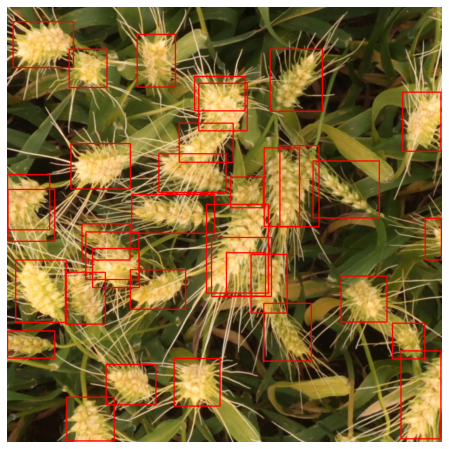

In [26]:
visualize(0)
# # visualize(1)

In [27]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()


,image_id,PredictionString
0,aac893a91,0.9304 554 80 135 174 0.9460 72 1 99 160 0.940...
1,51f1be19e,0.9262 612 88 149 157 0.8763 504 463 198 107 0...
2,f5a1f0358,0.9161 65 455 141 122 0.9608 941 437 80 182 0....
3,796707dd7,0.9519 895 330 111 92 0.8813 50 87 156 98 0.94...
4,51b3e36ab,0.9537 544 28 249 133 0.9628 833 448 186 148 0...


In [28]:
test_df.to_csv('submission.csv', index=False)
